Created by Emma Chen, Aric Shen
shen.aric@gmail.com

4/6/24

This notebook contains code used to wrangle, process, and visualize EEG data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne


from scipy import signal

In [7]:
# Loading EEG data

eeg     = np.loadtxt(r'C:\Users\ashen\Documents\Neurotech\EEGTetris\dc\DSI-7_0210\devin_eeg.csv', delimiter=',', skiprows=1)
markers = np.loadtxt(r'C:\Users\ashen\Documents\Neurotech\EEGTetris\dc\DSI-7_0210\devin_markers.csv', delimiter=',', skiprows=1)

Fs      = 300    # sampling rate of the DSI-7

In [11]:
# Corrects for DC offset in EEG data

def nodc(eeg, Fs):                                  # Read as 'no DC'
    """ Corrects for DC offset in EEG data

    Parameters
    ----------
    eeg: np.arr
        EEG data where the no. of rows = # of sampled timepoints and data channels are across column
        1st channel is time (s)

    Fs: int
        sampling rate

    Returns
    -------
    eeg_nodc: np.arr
        og. EEG data arr corrected for DC offset across channels
    """

    fft      = np.fft.fft(eeg[:, 1:], axis=0)       # Need to exclude 1st channel so you don't 'DC un-offset' time
    frq      = np.fft.fftfreq(eeg.shape[0], 1/Fs)

    dc_idx   = np.abs(frq).argmin()   
    fft[dc_idx] = 0  

    ifft     = np.fft.ifft(fft, axis=0)
    eeg_nodc = np.hstack((eeg[:, 0].reshape(-1, 1), ifft))

    return eeg_nodc

In [9]:
# MNE documentation (below)
# https://mne.tools/dev/generated/mne.filter.filter_data.html

# var_name = mne.filter.filter_data(t1_ndc.T[1:, :], sfreq=Fs, l_freq=8, h_freq=13)

In [10]:
# Epochs EEG data

def eeg_chop(eeg, markers):
    """ Epochs EEG data collected using the DSI-7 according to original (mislabeled) paradigm
    (ie. data collected on 02/10)

    Parameters
    ----------
    eeg: np.arr (n, 9)
        EEG data where n = # of timepoints and 9 channels of recording
        1st channel is time (s) and the remaining 8 are (in order): F3, Fz, F4, C3, C4, P3, P4, Gnd
            Gnd will read as column of 0s, can ignore

    markers: np.arr (m, 2) 
        m/2 = no. of trials
        Consists of corresponding marker #. Markers mark start+end of MI prompt presentation
        Marker encoding can be found under utils.py
        Functions (get_marker_name) found in utils.py can also decode marker # as needed

    Returns
    -------
    labels: np.arr (m/2, 1)
        processed markers arr to include only 'MI_TYPE' markers for each trial        

    baseline: np.arr (m/2, Fs * 2, 9)
        'baseline' epoch for each trial; consists of 2s (600 datapoints) before MI prompt
        9 channels like eeg arr

    motor_im: np.arr (m/2, Fs * 4, 9)
        active motor imagining epoch for each trial; consists of 4s (1200 datapoints) after MI prompt ends
        9 channels like eeg arr
    """
    eeg_f = eeg.copy()
    eeg_f[:, 0] = ['{:.3f}'.format(value) for value in eeg[:, 0]]
    
    marker_strt = markers[::2, :]
    marker_stop = markers[1::2, :]

    labels   = np.empty((marker_strt.shape[0], 1))
    baseline = np.empty((marker_strt.shape[0], 300 * 2, 9))
    motor_im = np.empty((marker_strt.shape[0], 300 * 4, 9))
    
    for i in range(marker_strt.shape[0]):
        end_idx = np.where(eeg[:, 0] <= marker_strt[0, 0])[0][-1]
        labels[i] = marker_strt[i, 1]
        baseline[i] = eeg[end_idx - 300 * 2:end_idx]

    for i in range(marker_stop.shape[0]):
        start_idx = np.where(eeg[:, 0] >= marker_stop[i, 0])[0][0]
        motor_im[i] = eeg[start_idx:start_idx + 300 * 4]

    return labels, baseline, motor_im

In [35]:
# we write a general bandpass filter
# I'm not too sure about how to select for filter order, so let's choose 4 for now

def bp_butter(eeg, Wn, Fs=Fs, n=4):  
    """ Butterworth band-pass filter

    Parameters
    ----------
    eeg: np.arr
        assumes 1st channel is time and EEG channels are across columns

    Wn: list of len 2
        list containing band-pass frequencies
        
    Fs: int
        sampling rate

    n: int
        order of filter

    Returns
    -------
    filt: np.arr
        Band-pass filtered eeg data returned w/ same size as eeg input
    """
    sos = signal.butter(n, Wn, btype='band', fs=Fs, output='sos')

    filt = signal.sosfilt(sos, eeg[:, 1:], axis=0)
    filt[:, 0] = eeg[:, 0]

    return filt

In [127]:
eeg_filt = mne.filter.filter_data(eeg.T[1:, :], sfreq=Fs, l_freq=7, h_freq=30)

Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 495 samples (1.650 s)



In [131]:
eeg_filtWithTime = np.column_stack((eeg[:, 0], eeg_filt.T))

In [125]:


eeg_filtWithTime.shape

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 35559 and the array at index 1 has size 8

c:\Users\ashen\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\ashen\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


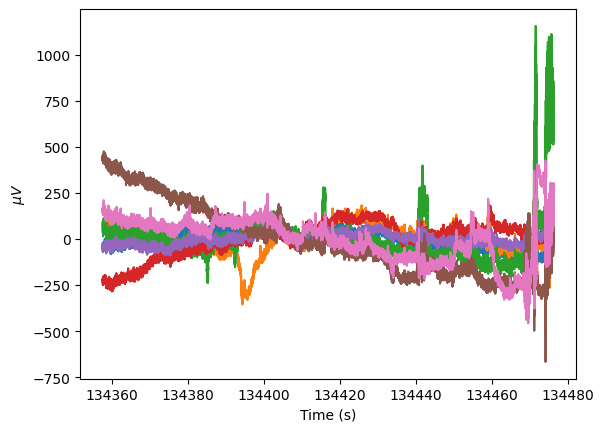

In [98]:
eeg_nodc = nodc(eeg, Fs)


for i in range(1, 8):
    fft    = np.fft.fft(eeg[:, i], axis=0)
    frq    = np.fft.fftfreq(eeg.shape[0], 1/Fs)
    
    dcidx  = np.abs(frq).argmin()      # DC component of signal = coefficient of fft at 0 Hz
    fft[dcidx] = 0                     # mask to remove DC component

    ifft   = np.fft.ifft(fft, axis=0)  # inverse fft to return corrected signal
    eeg_nodc[:, i]     = ifft
    
    plt.plot(eeg[:, 0], ifft)          # plot
eeg_nodc[:, 0] = eeg[:, 0]

plt.xlabel('Time (s)')
plt.ylabel(r'$\mu V$')

plt.show()


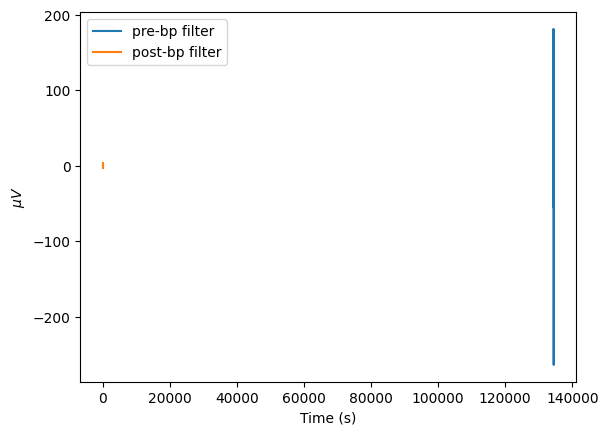

In [132]:
# eeg_filt = bp_butter(eeg_nodc, Wn=[7, 30])

# we can plot the first channel of the alpha-band filtered data with the raw data for comparison
plt.plot(eeg[:, 0], eeg[:, 1], label='pre-bp filter')
plt.plot(eeg_filt[:, 0], eeg_filt[:, 1], label='post-bp filter')

plt.xlabel('Time (s)')
plt.ylabel(r'$\mu V$')

plt.legend()

plt.show()

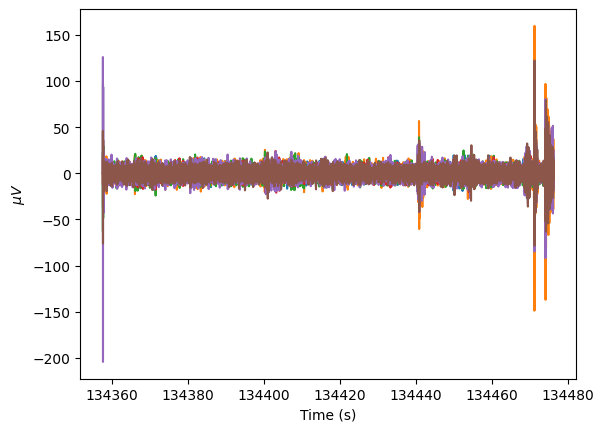

In [38]:
for i in range(1, eeg_filt.shape[-1]-1):
    plt.plot(eeg_filt[:, 0], eeg_filt[:, i])

plt.xlabel('Time (s)')
plt.ylabel(r'$\mu V$')

plt.show()

In [51]:
# Associates the integer code for a trial to a string describing the 
# trial's test. This is used later to title plots.
marker_dict = {
    0.: 'Left Arm',
    1: 'Left Arm End',
    2: 'Right Arm',
    3: 'Right Arm End',
    4: 'Left Leg',
    5: 'Left Leg End',
    6: 'Right Leg',
    7: 'Right Leg End'
}

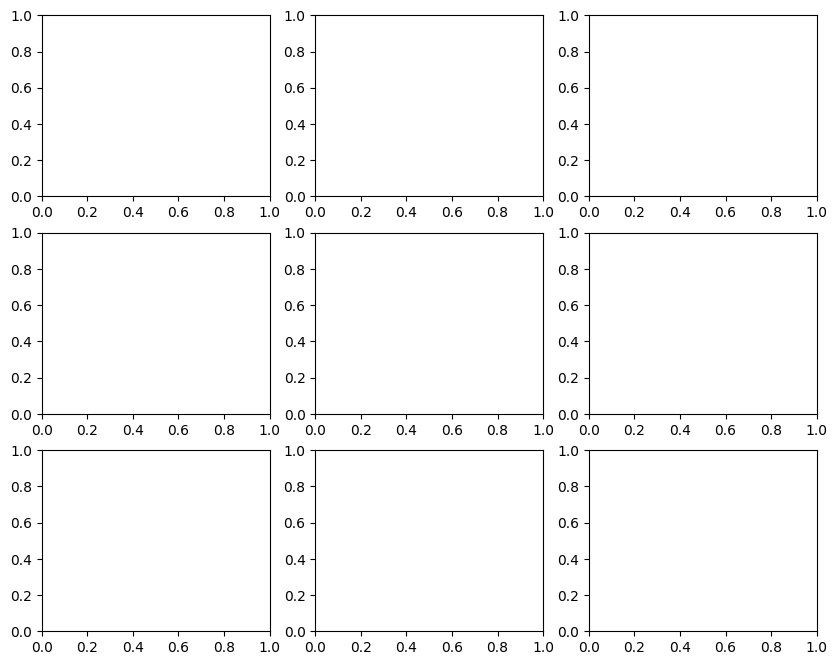

In [136]:

labels, baseline, motor_im = eeg_chop(eeg_filtWithTime, markers)

labels.shape, baseline.shape, motor_im.shape

((8, 1), (8, 600, 9), (8, 1200, 9))

[[0.]
 [4.]
 [6.]
 [2.]
 [0.]
 [4.]
 [6.]
 [2.]]


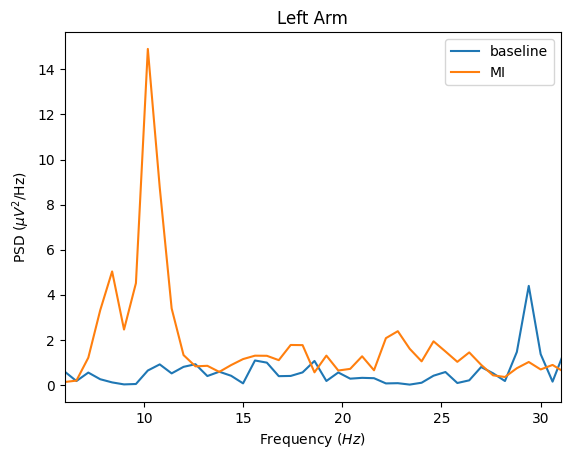

In [144]:
# let's quickly process a trial 1, channel 1 of a motor imagery trial for comparison

mt1       = motor_im[0, :, :]
baseline0 = baseline[0, :, :]
channel = 4

# t1 - baseline
wat1_frq, wat1_psd = signal.welch(baseline0[:, channel], Fs, nperseg=500)
plt.plot(wat1_frq, wat1_psd, label='baseline')

# t1_fft = np.fft.fft(mt1[:, 1:], axis=0)
# t1_freq = np.fft.fftfreq(mt1.shape[0], 1/Fs)

# plt.plot(t1_freq, np.abs(t1_fft[:, 0]**2))

# t1 - MI
mwat1_frq,  mwat1_psd = signal.welch(mt1[:, channel], Fs, nperseg=500)
plt.plot(mwat1_frq, mwat1_psd, label='MI')

plt.xlim(6, 31)

plt.xlabel(r'Frequency $(Hz)$')
plt.ylabel(r'PSD ($\mu V^2$/Hz)')

print(labels)
plt.title(marker_dict[(labels[0][0])])

# plt.semilogy()

plt.legend()
plt.show()


In [178]:
# Makes one subplot for a single channel of a trial. The parameter axes is the plot
# that this function modifies.
def plotOne(channel, trial, axes):
    mt1       = motor_im[trial, :, :]
    baseline0 = baseline[trial, :, :]
    graphLocation = divmod(channel, 3)
    # t1 - baseline
    wat1_frq, wat1_psd = signal.welch(baseline0[:, channel], Fs, nperseg=500)
    axes[graphLocation[0], graphLocation[1]].plot(wat1_frq, wat1_psd, label='baseline')

    mwat1_frq,  mwat1_psd = signal.welch(mt1[:, channel], Fs, nperseg=500)
    axes[graphLocation[0], graphLocation[1]].plot(mwat1_frq, mwat1_psd, label='MI')

    axes[graphLocation[0], graphLocation[1]].set_xlim(6, 31)

    axes[graphLocation[0], graphLocation[1]].set_xlabel(r'Frequency $(Hz)$')
    axes[graphLocation[0], graphLocation[1]].set_ylabel(r'PSD ($\mu V^2$/Hz)')

    print(labels)
    axes[graphLocation[0], graphLocation[1]].set_title(f'Channel {channel}')



In [177]:
# Plots one trial. The Trial parameter specifies which trial to plot.

# Makes 9 subplots. 2 are unused and the other 7 represent one EEG headset channel.
# Each subplot has two lines - the baseline (always pulled from the baseline trial),
# and the data from the trial corresponding to the trial parameter.
def plotOneTrial(trial):
    fig, axes = plt.subplots(3, 3, figsize=(10, 8))
    for i in range(8):
        plotOne(i, trial, axes)
    fig.suptitle(marker_dict[labels[trial][0]])
    plt.tight_layout()
    plt.show()


[[0.]
 [4.]
 [6.]
 [2.]
 [0.]
 [4.]
 [6.]
 [2.]]
[[0.]
 [4.]
 [6.]
 [2.]
 [0.]
 [4.]
 [6.]
 [2.]]
[[0.]
 [4.]
 [6.]
 [2.]
 [0.]
 [4.]
 [6.]
 [2.]]
[[0.]
 [4.]
 [6.]
 [2.]
 [0.]
 [4.]
 [6.]
 [2.]]
[[0.]
 [4.]
 [6.]
 [2.]
 [0.]
 [4.]
 [6.]
 [2.]]
[[0.]
 [4.]
 [6.]
 [2.]
 [0.]
 [4.]
 [6.]
 [2.]]
[[0.]
 [4.]
 [6.]
 [2.]
 [0.]
 [4.]
 [6.]
 [2.]]
[[0.]
 [4.]
 [6.]
 [2.]
 [0.]
 [4.]
 [6.]
 [2.]]


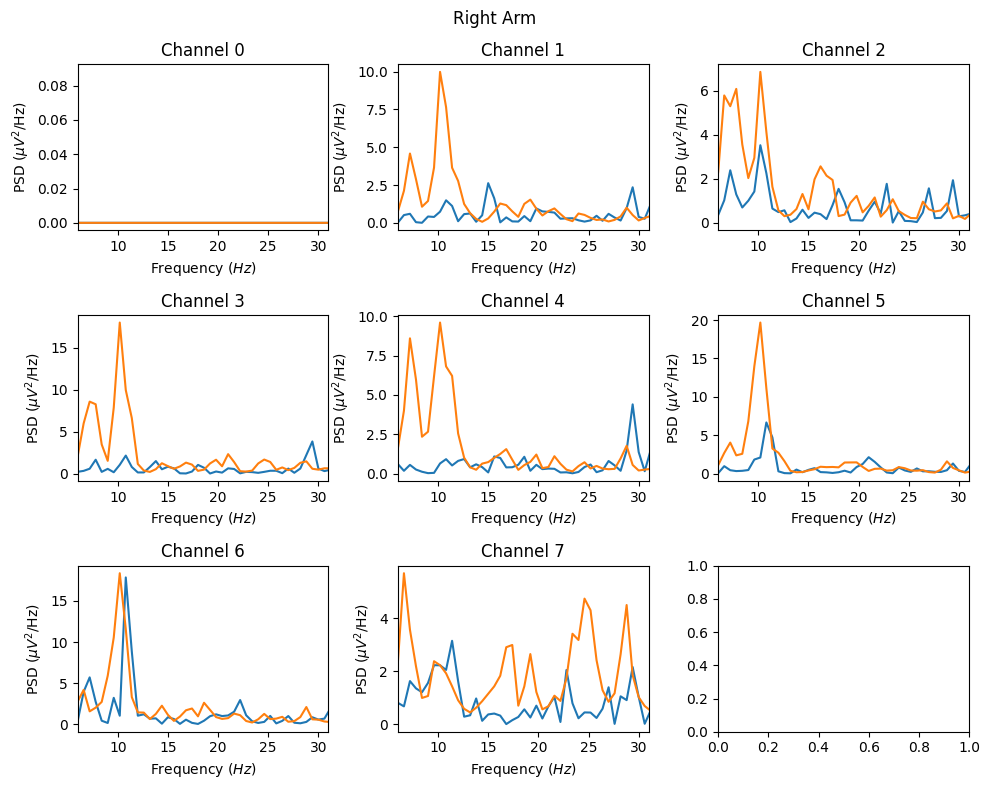

In [181]:
plotOneTrial(3)